# Flutter
* Professor: Elias Oliveira


# Persistência de dados Local com ***sqlitle***.
* O SQLite com certeza é um dos bancos locais mais populares do mercado, e isto significa que sua adoção e as chances de você precisar trabalhar com ele em algum projeto são grandes.

* SQLite é um banco de dados relacional rápido que pode ser usado para armazenar dados offline para aplicativos móveis. CRUD significa criar, ler, atualizar e excluir as quatro operações essenciais do armazenamento persistente.



### Dependências
Para trabalhar com Flutter SQLite precisamos utilizar o pacote ***sqflite***, que nos irá prover tudo que precisamos a nível de banco de dados.

flutter pub add sqflite


### Estrutura do Banco de Dados
<table>
    <tr>
        <th>Coluna</th>
        <th>Tipo</th>
        <th>Descrição</th>
    </tr>
    <tr>
        <td>id</td>
        <td>INTEIRO</td>
        <td>O id de um produto</td>
    </tr>
    <tr>
        <td>name</td>
        <td>TEXTO</td>
        <td>Nome do produto</td>
    </tr>
    <tr>
        <td>price</td>
        <td>REAL</td>
        <td>Valor do produto</td>
    </tr>
</table>


*** Um Exemplo *** Uma base de dados para registrar os produtos.

### Vamos criar uma classe auxiliar para acesso aos dados
* A vantagem de usar uma classe helper é que toda complexidade da persistencia está neste elemento.
* Código completo em sql_helper.dart:

In [ ]:
import 'package:flutter/foundation.dart';
import 'package:sqflite/sqflite.dart' as sql;

class SQLHelper {
  static Future<void> createTables(sql.Database database) async {
    await database.execute("""CREATE TABLE items(
        id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
        name TEXT,
        price REAL
      )
      """);
  }
// id: the id of a item
// name: Nome do produto
// price: preço da unidade do produto

  static Future<sql.Database> db() async {
    return sql.openDatabase(
      'produto.db',
      version: 1,
      onCreate: (sql.Database database, int version) async {
        await createTables(database);
      },
    );
  }

  // Criar um novo item (produto)
  static Future<int> createItem(String name, double? price) async {
    final db = await SQLHelper.db();

    final data = {'name': name, 'price': price};
    final id = await db.insert('items', data,
        conflictAlgorithm: sql.ConflictAlgorithm.replace);
    return id;
  }

  // lê todos items (produtos)
  static Future<List<Map<String, dynamic>>> getItems() async {
    final db = await SQLHelper.db();
    return db.query('items', orderBy: "id");
  }

  // Lê um item selecionado pelo id
  static Future<List<Map<String, dynamic>>> getItem(int id) async {
    final db = await SQLHelper.db();
    return db.query('items', where: "id = ?", whereArgs: [id], limit: 1);
  }

  // Atualiza um item identificado pelo id
  static Future<int> updateItem(
      int id, String name, double? price) async {
    final db = await SQLHelper.db();

    final data = {
      'name': name,
      'price': price
    };

    final result =
        await db.update('items', data, where: "id = ?", whereArgs: [id]);
    return result;
  }

  // Deleta um item.
  static Future<void> deleteItem(int id) async {
    final db = await SQLHelper.db();
    try {
      await db.delete("items", where: "id = ?", whereArgs: [id]);
    } catch (err) {
      debugPrint("Erro ao deletar item: $err");
    }
  }
}


### Vamos construtir nossa aplicação.
Criando a tela.


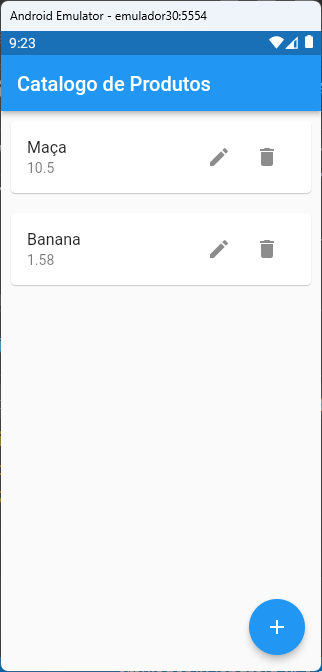

* Como o acesso a base de dados é assincrona. Precisamos prever que ao iniciar a aplicação os dados da base não foram lidas ainda, então devemos criar duas telas iniciais.
* Uma com a tela com um indicador circular 
* e uma com a lista de produtos, quando os dados estiverem disponíveis.
* Para isso usamos o operador ternário ?:

In [ ]:
body: _isLoading
          ? const Center(
              child: CircularProgressIndicator(),
            )
          : ListView.builder(

* Aqui vemos como exibir uma lista de produtos com tamanho dinâmico

In [ ]:
          : ListView.builder(
              itemCount: _produtos.length, //Tamanho da lista de produtos
              itemBuilder: (context, index) { 
                // cria um card para cada produto
                return Card(
                  margin: const EdgeInsets.all(10),
                  child: ListTile(
                    title: Text(_produtos[index]['name']),
                    subtitle: Text((_produtos[index]['price']).toString()),
                    trailing: SizedBox(
                      width: 100,
                      child: Row(
                        children: [
                          // Botão para alterar o elemento
                          IconButton(
                            icon: const Icon(Icons.edit),
                            onPressed: () => _showForm(_produtos[index]['id']),
                          ),
                          // Botão para deletar produto
                          IconButton(
                            icon: const Icon(Icons.delete),
                            onPressed: () =>
                                _deleteItem(_produtos[index]['id']),
                          ),
                        ],
                      ),
                    ),
                  ),
                );
              }),


* Ao selecionarmos Criar ou alterar uma tela modal é aberta na aplicação.

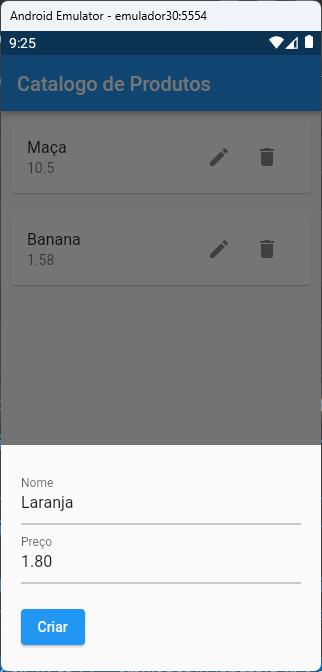

In [ ]:
  void _showForm(int? id) async {
    var action = 'create';
    if (id != null) {
      // id == null -> create new item
      // id != null -> update an existing item
      action = 'update';
      final existingproduto =
          _produtos.firstWhere((element) => element['id'] == id);
      _nameController.text = existingproduto['name'];
      _priceController.text = existingproduto['price'].toString();
    }

    //exibe em uma tela modal para edição/inclusão
    showModalBottomSheet(
        isScrollControlled: true,
        context: context,
        builder: (BuildContext ctx) {
          return Padding(
            padding: EdgeInsets.only(
                top: 20,
                left: 20,
                right: 20,
                // impede que o teclado cubra os campos de texto
                bottom: MediaQuery.of(ctx).viewInsets.bottom + 20),
            child: Column(
              mainAxisSize: MainAxisSize.min,
              crossAxisAlignment: CrossAxisAlignment.start,
              children: [
                TextField(
                  controller: _nameController,
                  decoration: const InputDecoration(labelText: 'Nome'),
                ),
                TextField(
                  keyboardType:
                      const TextInputType.numberWithOptions(decimal: true),
                  controller: _priceController,
                  decoration: const InputDecoration(
                    labelText: 'Preço',
                  ),
                ),
                const SizedBox(
                  height: 20,
                ),
                ElevatedButton(
                  child: Text(action == 'create' ? 'Criar' : 'Atualizar'),
                  onPressed: () async {
                    final String name = _nameController.text;
                    final double? price =
                        double.tryParse(_priceController.text);
                    if (name != null && price != null) {
                      if (action == 'create') {
                        // Persiste um novo produto no Firestore
                        await _addItem();
                      }

                      if (action == 'update') {
                        // Atualiza produto
                        await _updateItem(id!);
                      }

                      // Limpa os campos de texto
                      _nameController.text = '';
                      _priceController.text = '';

                      // Volta para a tela principal
                      Navigator.of(context).pop();
                    }
                  },
                )
              ],
            ),
          );
        });
  }


### Abaixo o código completo main.dat

In [ ]:
// main.dart
import 'package:flutter/material.dart';
import 'sql_helper.dart';

void main() {
  runApp(const MyApp());
}

class MyApp extends StatelessWidget {
  const MyApp({Key? key}) : super(key: key);

  @override
  Widget build(BuildContext context) {
    return const MaterialApp(
      // Remove the debug banner
      debugShowCheckedModeBanner: false,
      title: 'Cadastro de Produtos',
      home: HomePage(),
    );
  }
}

class HomePage extends StatefulWidget {
  const HomePage({Key? key}) : super(key: key);

  @override
  State<HomePage> createState() => _HomePageState();
}

class _HomePageState extends State<HomePage> {
  // Prove acesso aos campos de texto do formulário
  final TextEditingController _nameController = TextEditingController();
  final TextEditingController _priceController = TextEditingController();
  // All produtos
  List<Map<String, dynamic>> _produtos = [];

  bool _isLoading = true;
  // This function is used to fetch all data from the database
  void _refreshprodutos() async {
    final data = await SQLHelper.getItems();
    setState(() {
      _produtos = data;
      _isLoading = false;
    });
  }

  @override
  void initState() {
    super.initState();
    _refreshprodutos(); // Loading the diary when the app starts
  }

  // This function will be triggered when the floating button is pressed
  // It will also be triggered when you want to update an item
  void _showForm(int? id) async {
    var action = 'create';
    if (id != null) {
      // id == null -> create new item
      // id != null -> update an existing item
      action = 'update';
      final existingproduto =
          _produtos.firstWhere((element) => element['id'] == id);
      _nameController.text = existingproduto['name'];
      _priceController.text = existingproduto['price'].toString();
    }

    //exibe em uma tela modal para edição/inclusão
    showModalBottomSheet(
        isScrollControlled: true,
        context: context,
        builder: (BuildContext ctx) {
          return Padding(
            padding: EdgeInsets.only(
                top: 20,
                left: 20,
                right: 20,
                // impede que o teclado cubra os campos de texto
                bottom: MediaQuery.of(ctx).viewInsets.bottom + 20),
            child: Column(
              mainAxisSize: MainAxisSize.min,
              crossAxisAlignment: CrossAxisAlignment.start,
              children: [
                TextField(
                  controller: _nameController,
                  decoration: const InputDecoration(labelText: 'Nome'),
                ),
                TextField(
                  keyboardType:
                      const TextInputType.numberWithOptions(decimal: true),
                  controller: _priceController,
                  decoration: const InputDecoration(
                    labelText: 'Preço',
                  ),
                ),
                const SizedBox(
                  height: 20,
                ),
                ElevatedButton(
                  child: Text(action == 'create' ? 'Criar' : 'Atualizar'),
                  onPressed: () async {
                    final String name = _nameController.text;
                    final double? price =
                        double.tryParse(_priceController.text);
                    if (name != null && price != null) {
                      if (action == 'create') {
                        // Persiste um novo produto no Firestore
                        await _addItem();
                      }

                      if (action == 'update') {
                        // Atualiza produto
                        await _updateItem(id!);
                      }

                      // Limpa os campos de texto
                      _nameController.text = '';
                      _priceController.text = '';

                      // Volta para a tela principal
                      Navigator.of(context).pop();
                    }
                  },
                )
              ],
            ),
          );
        });
  }

// Insert a new produto to the database
  Future<void> _addItem() async {
    await SQLHelper.createItem(
        _nameController.text, double.parse(_priceController.text));
    _refreshprodutos();
  }

  // Update an existing produto
  Future<void> _updateItem(int id) async {
    await SQLHelper.updateItem(
        id, _nameController.text, double.parse(_priceController.text));
    _refreshprodutos();
  }

  // Delete an item
  void _deleteItem(int id) async {
    await SQLHelper.deleteItem(id);
    ScaffoldMessenger.of(context).showSnackBar(const SnackBar(
      content: Text('Registro deletado!'),
    ));
    _refreshprodutos();
  }

  // Desenha a tela do app
  @override
  Widget build(BuildContext context) {
    return Scaffold(
      appBar: AppBar(
        title: const Text('Catalogo de Produtos'),
      ),
      // Using StreamBuilder to display all products from Firestore in real-time
      body: _isLoading
          ? const Center(
              child: CircularProgressIndicator(),
            )
          : ListView.builder(
              itemCount: _produtos.length,
              itemBuilder: (context, index) {
                return Card(
                  margin: const EdgeInsets.all(10),
                  child: ListTile(
                    title: Text(_produtos[index]['name']),
                    subtitle: Text((_produtos[index]['price']).toString()),
                    trailing: SizedBox(
                      width: 100,
                      child: Row(
                        children: [
                          // Botão para alterar o elemento
                          IconButton(
                            icon: const Icon(Icons.edit),
                            onPressed: () => _showForm(_produtos[index]['id']),
                          ),
                          // Botão para deletar produto
                          IconButton(
                            icon: const Icon(Icons.delete),
                            onPressed: () =>
                                _deleteItem(_produtos[index]['id']),
                          ),
                        ],
                      ),
                    ),
                  ),
                );
              }),
      // Add new product
      floatingActionButton: FloatingActionButton(
        onPressed: () => _showForm(null),
        child: const Icon(Icons.add),
      ),
    );
  }
}


### Desafio
* Altere a aplicação para criar uma agenda telefonica com o nome, numero fone e email.
* inclua a funcionalidade que busca um nome na agenda.


## Bibliografia
* https://www.kindacode.com/article/flutter-sqlite/
* https://balta.io/blog/flutter-sqlite